## This source code is about building a model for predicting Bitcoin stock prices using the Deep Learning LSTM model and Time Series ARIMA model 

First we import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
import datetime as dt
from pandas_datareader import data
import pandas_datareader as pdr
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from sklearn.preprocessing import MinMaxScaler  # while working with neural network models its best practise to scale the data
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now we import and load the dataset for which we will use the pandas data reader library ... 

We will be taking the Bitcoin(BTC) stock price data vs the US dollar(USD) from the yahoo finance API

And we will be taking the stock price data from the 1st of January 2016 till the current day

In [2]:
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 4.8 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
start = dt.datetime(2016,1,1) # defining the range of the dataset
end = dt.datetime.now()
BTC = pdr.DataReader('BTC-USD','yahoo',start,end)
BTC.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600,431.959991


In [4]:
BTC.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-06-22,20835.750000,19848.078125,20719.414062,19987.029297,28574793478,19987.029297
2022-06-23,21135.761719,19950.117188,19986.607422,21085.876953,26188097173,21085.876953
2022-06-24,21472.917969,20777.511719,21084.648438,21231.656250,24957784918,21231.656250
2022-06-25,21520.914062,20964.585938,21233.609375,21502.337891,18372538715,21502.337891
2022-06-26,21773.453125,21335.117188,21471.253906,21394.855469,18227451904,21394.855469


In [5]:
BTC.shape

(2369, 6)

Open - The brice of the bitcoin at the beginning of the day

High - Maximum price at the given time period

Low - Minimum price at the given time period

Close - Price of the bitcoin in USD at the close of the day

Volume - how much - in monetary terms - a given cryptocurrency has traded over a period of time

Adj Close - the closing price after adjustments

**Now we explore,analyse and visualize the data**

In [ ]:
#making a copy of data for EDA

BTC_EDA = BTC.copy()
BTC_EDA.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988


In [ ]:
BTC_EDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2369 entries, 2016-01-01 to 2022-06-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2369 non-null   float64
 1   Low        2369 non-null   float64
 2   Open       2369 non-null   float64
 3   Close      2369 non-null   float64
 4   Volume     2369 non-null   int64  
 5   Adj Close  2369 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 129.6 KB


In [ ]:
BTC_EDA.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2369.000000,2369.000000,2369.000000,2369.000000,2.369000e+03,2369.000000
mean,15199.858482,14380.082835,14813.847240,14820.729521,1.845172e+10,14820.729521
std,17640.369303,16679.958577,17196.726160,17190.662413,2.051053e+10,17190.662413
min,374.950012,354.914001,365.072998,364.330994,2.851400e+07,364.330994
25%,3476.065430,3280.228760,3373.820068,3399.471680,1.557330e+09,3399.471680
50%,8215.526367,7814.763184,8033.261719,8037.537598,1.342527e+10,8037.537598
75%,17853.939453,16526.423828,17462.099609,17429.500000,3.030646e+10,17429.500000
max,68789.625000,66382.062500,67549.734375,67566.828125,3.509679e+11,67566.828125


Visualising the stock's daily closing price over the past 5 years

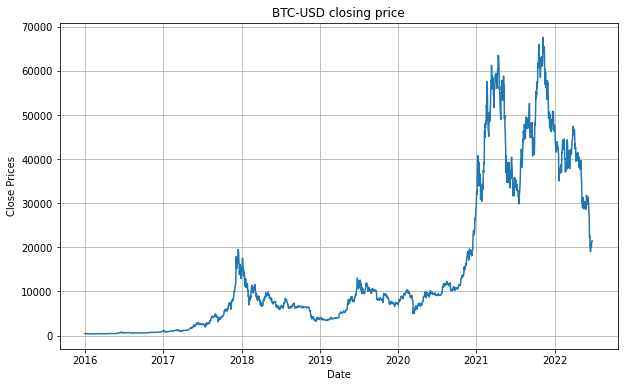

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(BTC_EDA['Close'])
plt.title('BTC-USD closing price')
plt.show()

From the above graph we see that the Bitcoin price spiked around early 2021

Now visualizing the distribution of the data

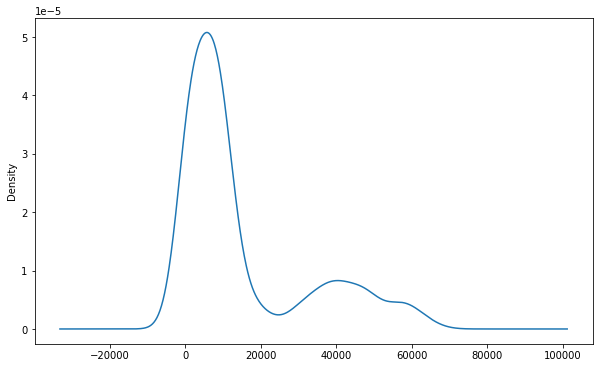

In [ ]:
BTC_close = BTC_EDA['Close']
BTC_close.plot(kind='kde')

{'boxes': [<matplotlib.lines.Line2D at 0x7fec8c73a490>],
 'caps': [<matplotlib.lines.Line2D at 0x7fec8bc22810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fec8c4fff50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fec8bbdfb50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fec8b7500d0>,
  <matplotlib.lines.Line2D at 0x7fec8c65cd90>]}

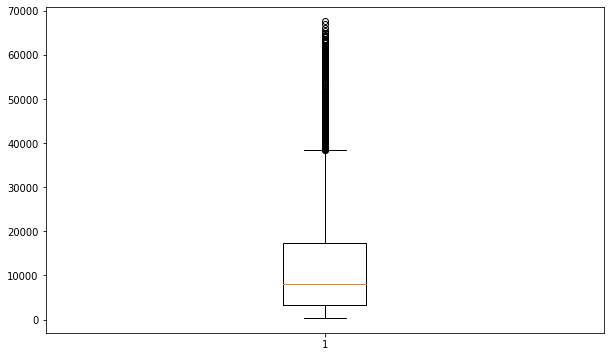

In [ ]:
plt.boxplot(BTC_EDA['Close'])

We see that distribution of the closing price is slightly right skewed and also has several outliers because the sudden spike in the prices in 2021 reaching a maximum of 65000 USD while the previous 5 years had uniform distribution inbetween 0 to 20000 USD 

(array([1041.,  690.,   84.,   24.,   78.,  132.,  129.,   78.,   80.,
          33.]),
 array([  364.33099365,  7084.58070679, 13804.83041992, 20525.08013306,
        27245.32984619, 33965.57955933, 40685.82927246, 47406.0789856 ,
        54126.32869873, 60846.57841187, 67566.828125  ]),
 <a list of 10 Patch objects>)

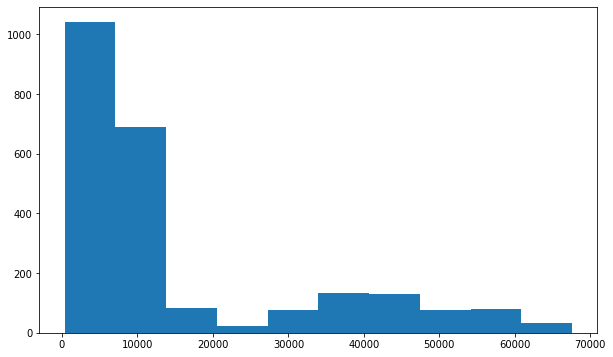

In [ ]:
plt.hist(BTC_EDA['Close'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fec7f992550>],
 'cbars': <matplotlib.collections.LineCollection at 0x7fec7ed46350>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fec81cc1310>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fec7ed46a50>}

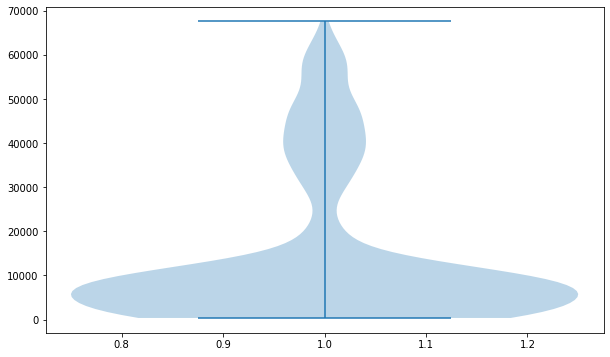

In [ ]:
plt.violinplot(BTC_EDA['Close'])

In [ ]:
#creating a copy of dataset for scatter plot

BTC_scatter = BTC_EDA.copy()
BTC_scatter.reset_index(inplace= True)
BTC_scatter.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
1,2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988


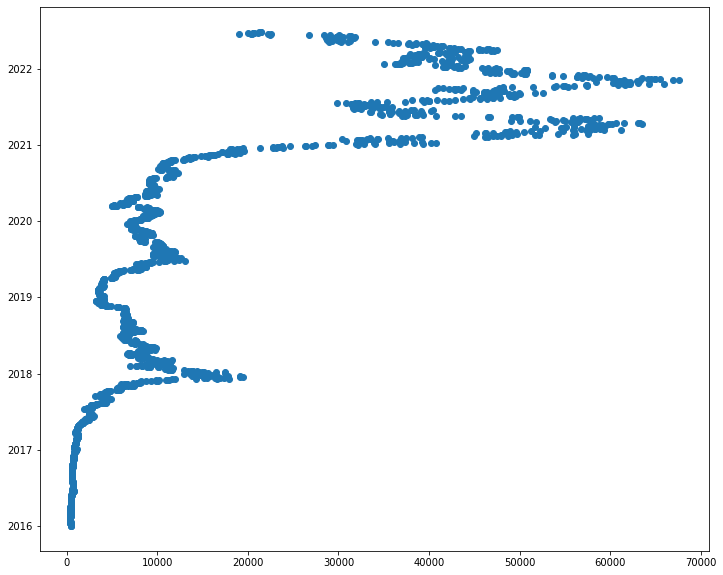

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(BTC_scatter['Close'], BTC_scatter['Date'])

From the violin plot we see that the majority of the datapoints are within the range of 0-30000 USD while very few data points are above 30000 USD till 70000 USD .... we are analysing the last 5 years .... and a remarkable upward spike in prices in the last year ....

We will build a model on a dataset that has a significant change in trend

<Figure size 864x720 with 0 Axes>

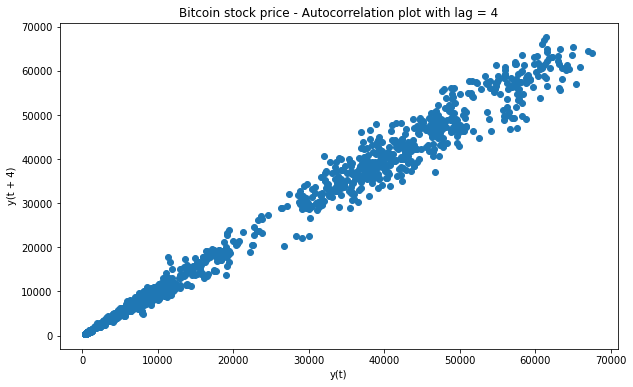

In [ ]:
# checking the auto correlation plot

BTC_1 = BTC.copy()

plt.figure(figsize=(12,10))
plt.figure()
lag_plot(BTC_1['Close'], lag=4)
plt.title('Bitcoin stock price - Autocorrelation plot with lag = 4')
plt.show()

We see from the above lag plot the Close price data is linear , hence it is an auto regressive model and also there is no randomness in the data

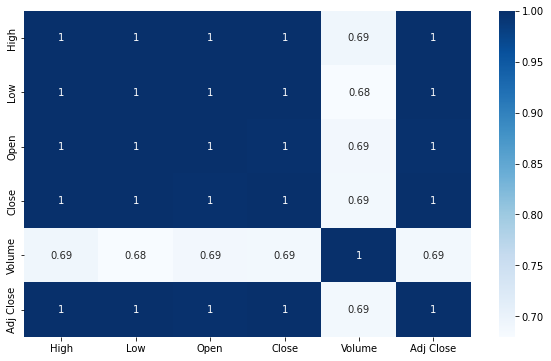

In [ ]:
# lets visualize the correlation between the features through a heat map

sns.heatmap(BTC_EDA.corr(), cmap = 'Blues' , annot = True)

In the above heat map , we see that most values are 1 or cloe to 1 which indicates high correlation . This happens because of very minute difference in the values of the dataset

However in the stock market , even those differences matter

So creating new features to understand more about the dataset

In [ ]:
BTC_EDA['open-high'] = BTC_EDA['Open']-BTC_EDA['High']
BTC_EDA['open-low'] = BTC_EDA['Open'] - BTC_EDA['Low']
BTC_EDA['close-high'] = BTC_EDA['Close']-BTC_EDA['High']
BTC_EDA['close-low'] = BTC_EDA['Close'] - BTC_EDA['Low']
BTC_EDA['high-low'] = BTC_EDA['High'] - BTC_EDA['Low']
BTC_EDA['open-close'] = BTC_EDA['Open'] - BTC_EDA['Close']
BTC_EDA.head()

,High,Low,Open,Close,Volume,Adj Close,open-high,open-low,close-high,close-low,high-low,open-close
Date,,,,,,,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015,-5.524994,3.205994,-1.911987,6.819000,8.730988,-3.613007
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988,-1.440002,2.752014,-2.624023,1.567993,4.192017,1.184021
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800,430.010986,-0.165009,8.872009,-3.732025,5.304993,9.037018,3.567017
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500,433.091003,-4.455994,0.976990,-1.425995,4.006989,5.432983,-3.029999
2016-01-05,434.182007,429.675995,433.069000,431.959991,34522600,431.959991,-1.113007,3.393005,-2.222015,2.283997,4.506012,1.109009


dropping the unnecessary features and visualizing the correlation again with the newly created features

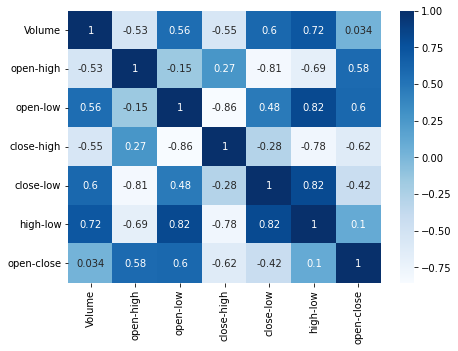

In [ ]:
BTC_heat = BTC_EDA.copy()
BTC_heat = BTC_heat.drop(['Open','High','Low','Close', 'Adj Close'],axis=1)
plt.figure(figsize=(7,5))
sns.heatmap(BTC_heat.corr(),cmap='Blues',annot=True)

The above heatmap now gives us more information on the data

We check the correlation between the new features created and volume

tells us how the change in feature impacts the number of stocks traded

Now lets visualize the new features created with volume



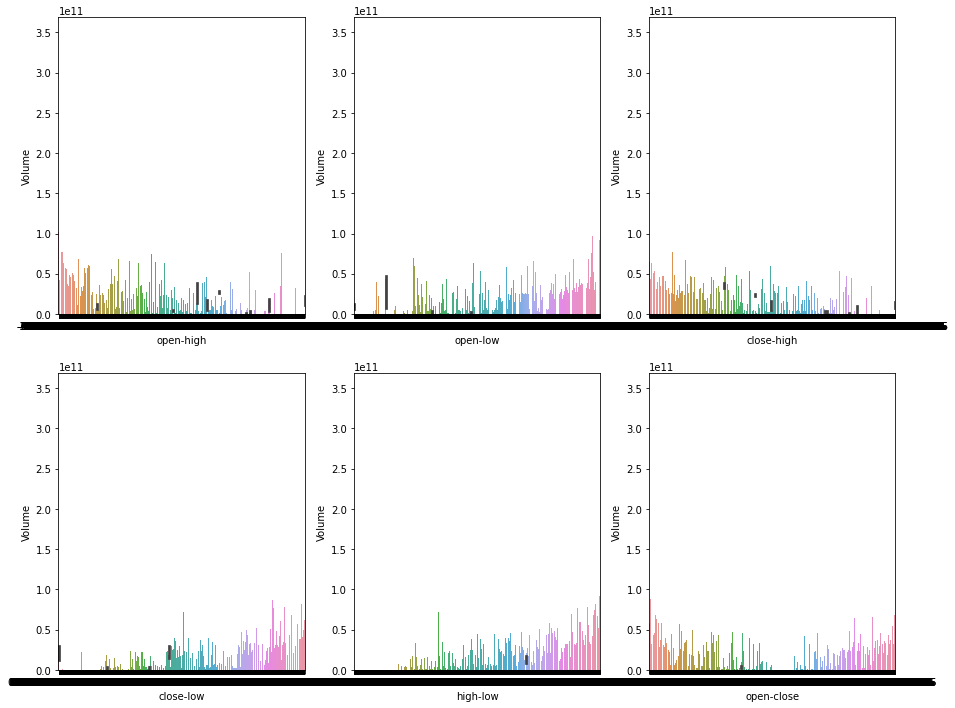

In [ ]:
plt.figure(figsize=(15,12))

plt.subplot(2, 3, 1)
sns.barplot(data=BTC_heat, x = "open-high", y="Volume")

plt.subplot(2, 3, 2)
sns.barplot(data=BTC_heat, x = "open-low", y="Volume")

plt.subplot(2, 3, 3)
sns.barplot(data=BTC_heat, x = "close-high", y="Volume")

plt.subplot(2, 3, 4)
sns.barplot(data=BTC_heat, x = "close-low", y="Volume")

plt.subplot(2, 3, 5)
sns.barplot(data=BTC_heat, x = "high-low", y="Volume")

plt.subplot(2, 3, 6)
sns.barplot(data=BTC_heat, x = "open-close", y="Volume")


From the above plots , we can make the following inferences

"Open-High" and "Close-high" have a negative correlation

"Open-low" and "Close-low" have a postive correlation

and also "Open-High" and "Close-high" have higher volume for smaller values

while "Open-low" and "Close-low" have higher volume for higher values

**We can start building the model now for predictions 
As mentioned earlier we will be using both the ARIMA model and LSTM network to make our predictions**





# ARIMA MODEL








We will first check if the Bitcoin Close price dataset is stationary



In [ ]:
BTC_ARIMA = BTC.copy()
BTC_ARIMA.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988


Now we will find out if the data is stationary in two ways

 Method1   --> Computing and plotting the moving average and moving standard Deviation with the original dataset with a rolling window of 12 months . if the graph isnt constant we will , data is not stationary

 Method2   --> We will perform Dickey Fuller Hypothesis test



=========================================================================


**Method 1  Computing and plotting the moving average and moving Standard Deviation with the original dataset with a rolling window of 12 months if the graph isnt constant we will  data is not stationary **=

In [ ]:
rolling_mean = BTC_ARIMA['Close'].rolling(12).mean()
rolling_std = BTC_ARIMA['Close'].rolling(12).std()
print(rolling_mean) , print(rolling_std)

Date
2016-01-01             NaN
2016-01-02             NaN
2016-01-03             NaN
2016-01-04             NaN
2016-01-05             NaN
                  ...     
2022-06-22    22009.307617
2022-06-23    21403.063151
2022-06-24    20942.147135
2022-06-25    20860.059570
2022-06-26    20793.174642
Name: Close, Length: 2369, dtype: float64
Date
2016-01-01            NaN
2016-01-02            NaN
2016-01-03            NaN
2016-01-04            NaN
2016-01-05            NaN
                 ...     
2022-06-22    2818.267590
2022-06-23    1987.911211
2022-06-24    1054.195247
2022-06-25     956.783706
2022-06-26     878.970059
Name: Close, Length: 2369, dtype: float64


(None, None)

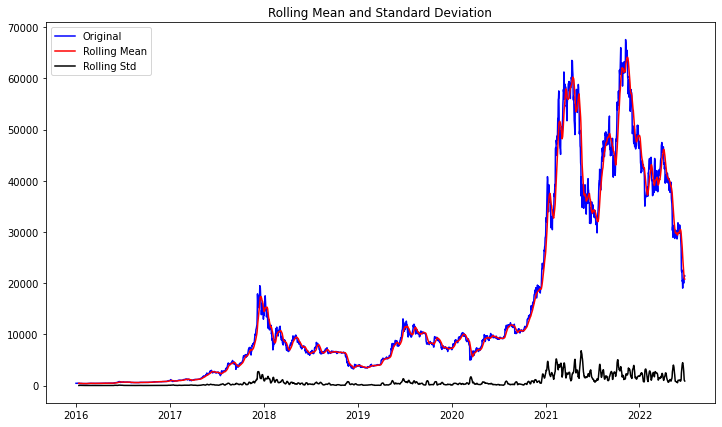

In [ ]:
#plotting rolling mean and standard deviation with original

plt.figure(figsize=(12,7))
plt.plot(BTC_ARIMA['Close'], color='blue',label='Original' )
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend()
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

From the above graph we see that the graph is not constant , hence data is not stationary

====================================================================

Method 2 - Perform Dickey Fuller Hypothesis Test

where, 

Null Hypothesis H0 : The Close price data is not stationary

Alternate Hypotheis H1 : The data is stationary

In [ ]:
adf = adfuller(BTC_ARIMA['Close'],autolag='AIC')

In [ ]:
#writing a for loop to explain the values

output = pd.Series(adf[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adf[4].items():
    output['critical value (%s)'%key] =  values
    print(output)

Test Statistics                  -1.547372
p-value                           0.509961
No. of lags used                 27.000000
Number of observations used    2341.000000
critical value (1%)              -3.433146
dtype: float64
Test Statistics                  -1.547372
p-value                           0.509961
No. of lags used                 27.000000
Number of observations used    2341.000000
critical value (1%)              -3.433146
critical value (5%)              -2.862775
dtype: float64
Test Statistics                  -1.547372
p-value                           0.509961
No. of lags used                 27.000000
Number of observations used    2341.000000
critical value (1%)              -3.433146
critical value (5%)              -2.862775
critical value (10%)             -2.567428
dtype: float64


We see that the p-value = 0.510096 , which is greater than 0.05 

hence we fail to reject the null hypothesis ....

From both the moving average/standard deviation graph and the Dickey Fuller test , 

we can confirm the data is not stationary 

Hence to make it stationary we first decompose the seasonlity and trend using seasonal decompose

<Figure size 720x432 with 0 Axes>

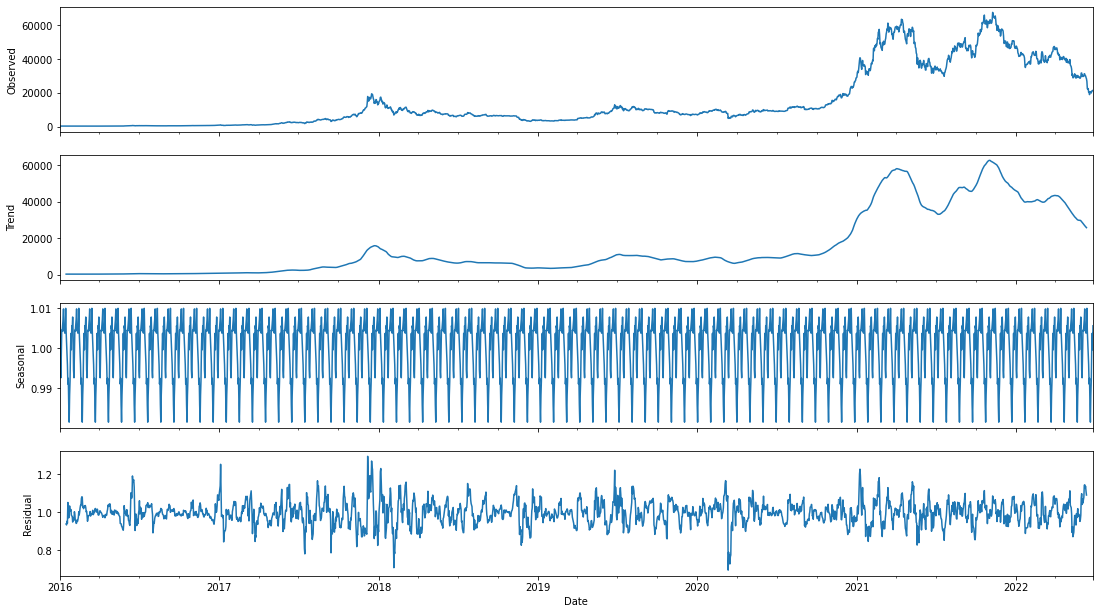

In [ ]:
result = seasonal_decompose(BTC_ARIMA['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

From the above graph we see that the trend is increasing

To reduce that we transform the data using log transformation and plot the rolling average/standard deviation and log transformned data

In [ ]:
df_log = np.log(BTC_ARIMA['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

In [ ]:
df_log.head(2)

Date
2016-01-01    6.073814
2016-01-02    6.071749
Name: Close, dtype: float64

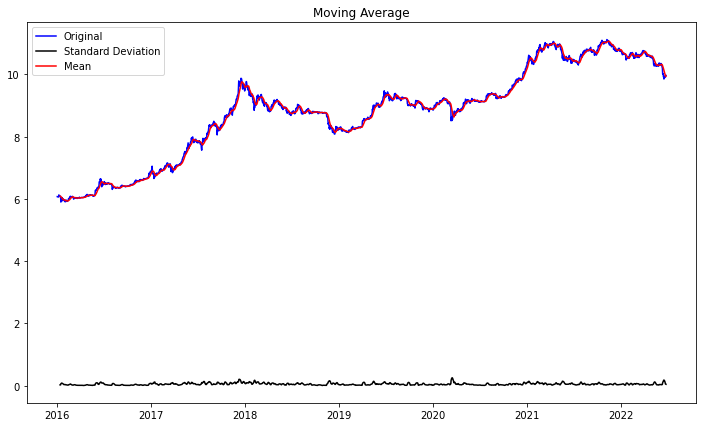

In [ ]:
plt.figure(figsize = (12,7))
plt.title('Moving Average')
plt.plot(df_log, color='blue',label='Original' )
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now the data is stationary and the Auto Arima can be performed 

But we will build an ARIMA model testing assuming values of p,d,q 

for which we begin by performing train and test split on the original dataset

In [ ]:
BTC_ARIMA1 = BTC.copy()
BTC_ARIMA1.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988


In [ ]:
#80% percent train_data and 20% test data

split_marker = int(len(BTC_ARIMA1)*0.8)
train_data = list(BTC_ARIMA1[0:split_marker]['Adj Close'])

In [ ]:
test_data = list(BTC_ARIMA1[split_marker:]['Adj Close'])

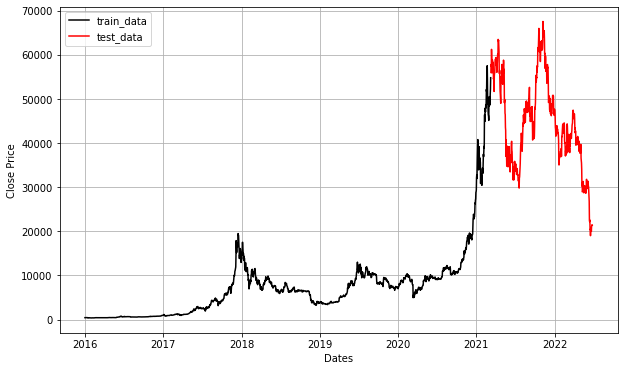

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.plot(BTC_ARIMA1[0:split_marker]['Adj Close'], 'black' , label='train_data')
plt.plot(BTC_ARIMA1[split_marker:]['Adj Close'], 'red' , label='test_data')
plt.legend()

In [ ]:
model_predictions = []
no_test_obs = len(test_data)
no_test_obs

474

In [ ]:
for i in range(no_test_obs):
  model = ARIMA(train_data , order = (4,1,1))
  model_fit = model.fit()
  output = model_fit.forecast()
  print(output)
  break

(array([55050.02221668]), array([522.83679936]), array([[54025.28092015, 56074.76351321]]))


In [ ]:
list(output[0])[0]

55050.02221668262

In [ ]:
for i in range(no_test_obs):
  model = ARIMA(train_data , order = (4,1,1)) #assuming p,d,q as (3,2,1)
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = list(output[0])[0]
  model_predictions.append(yhat)
  actual_test_value = test_data[i]
  train_data.append(actual_test_value)
  #print(output)
 # break

In [ ]:
len(model_predictions)

475

In [ ]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2368
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -19422.035
Method:                       css-mle   S.D. of innovations            882.653
Date:                Sun, 26 Jun 2022   AIC                          38858.070
Time:                        10:27:47   BIC                          38898.458
Sample:                             1   HQIC                         38872.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8979     19.262      0.462      0.644     -28.854      46.650
ar.L1.D.y      0.3823      0.309      1.238      0.216      -0.223       0.988
ar.L2.D.y      0.0157      0.024      0.660      0.5

<function matplotlib.pyplot.show>

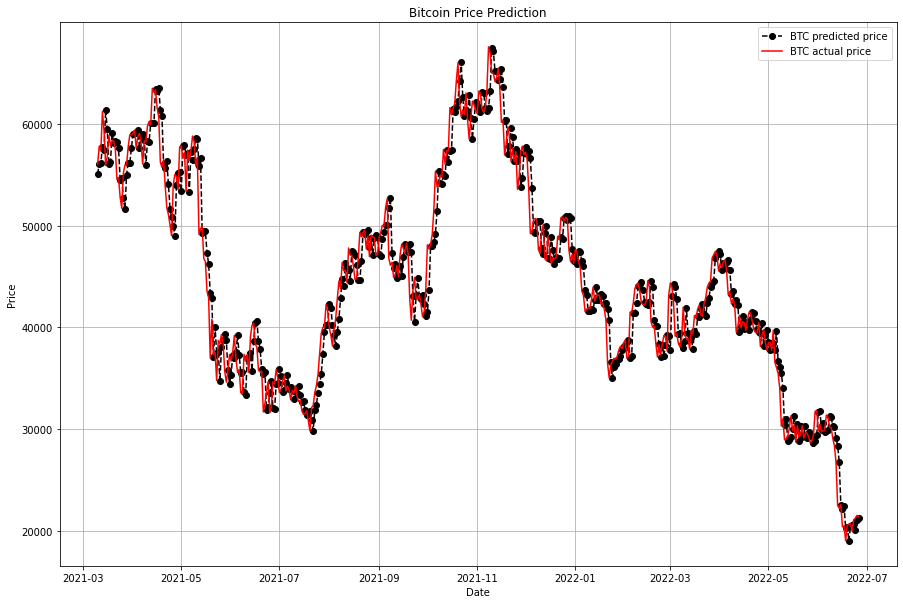

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)

date_range = BTC_ARIMA1[split_marker:].index

plt.plot(date_range , model_predictions[:-1] , color = 'black' , marker = 'o' , linestyle='dashed' , label = "BTC predicted price")
plt.plot(date_range ,test_data , color = 'red' , label = "BTC actual price")

plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show


In [ ]:
mape = np.mean(np.abs(np.array(model_predictions[:-1]) - np.array(test_data))/np.abs(test_data))
print('MAPE: ', str(mape))

MAPE:  0.04132690290820174


=================================================================================

# LSTM Model for Bitcoin Price prediction

In [ ]:
BTC_LSTM = BTC.copy()
BTC_LSTM.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988


**Data Preprocessing**

For LSTM Neural Network we will have to scale the data to either range(0,1)
or range(-1,1) 

here we will scale the Bitcoin close price to (0,1) using MixMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(BTC['Close'].values.reshape(-1,1))

In [ ]:
#defining the number of days on which the model should train

learning_days = 90

In [ ]:
#we initiate empty lists for X_train and Y_train and later fill it

X_train = []
y_train = []

**Defining the time frame for the training data**

In [ ]:
# 0 , 1, 2 , 3, ........... 89 --> X_train
# 100

for i in range(learning_days, len(scaled_data)):
  X_train.append(scaled_data[i-learning_days:i , 0]) #defining time period of X-train from (i-learning days which is 0 to i tp predict i with 0 as the dimension)
  y_train.append(scaled_data[i,0])  # defining the next day after learnings days

In [ ]:
#converting to array

X_train = np.array(X_train) 
y_train = np.array(y_train)

In [ ]:
X_train[0:3]

array([[1.04167292e-03, 1.02833968e-03, 9.77344526e-04, 1.02317641e-03,
        1.00634650e-03, 9.63863251e-04, 1.39454655e-03, 1.32285289e-03,
        1.23923965e-03, 1.24489427e-03, 1.25139718e-03, 1.06185055e-03,
        1.01246250e-03, 9.81734443e-04, 0.00000000e+00, 3.45299923e-04,
        2.67371279e-04, 3.39823765e-04, 2.35378056e-04, 8.31799706e-04,
        6.83471623e-04, 2.70243094e-04, 3.44630105e-04, 5.74978852e-04,
        4.07648833e-04, 4.14002793e-04, 4.55950188e-04, 2.37461530e-04,
        2.25333968e-04, 2.07194849e-04, 6.60095209e-05, 1.29831576e-04,
        1.50545066e-04, 8.35982547e-05, 3.75923538e-04, 3.30612976e-04,
        1.81407091e-04, 1.82865250e-04, 1.35649681e-04, 1.74070883e-04,
        2.57698656e-04, 2.28012331e-04, 2.96596223e-04, 4.09642392e-04,
        6.38354513e-04, 5.33521899e-04, 6.42193591e-04, 7.73646807e-04,
        8.63688027e-04, 8.40058218e-04, 1.08378425e-03, 1.10809886e-03,
        1.09247417e-03, 8.39328912e-04, 9.02109230e-04, 8.959936

In [ ]:
y_train[0:3]

array([0.0007797 , 0.00079802, 0.00084137])

we see that since we defined the learning days as 90 , 90 will be the number of features in X_train dataset and the target variable y_train will have just one feature both with 2277 records

In [ ]:
print(X_train.shape), print(y_train.shape) 

(2279, 90, 1)
(2279,)


(None, None)

In [ ]:
#adding one more dimension to the train data

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

**BUILDING NEURAL NETWORK**

with 2 LSTM layers and then adding dropout layers to avoid overfitting and finally a Dense layer for the output 

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1] , 1))) #first LSTM layer
model.add(Dropout(0.2)) # adding dropout layers to avoid overfitting
model.add(LSTM(units = 50 , return_sequences = True)) #second lstm layer
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #final output layer

In [ ]:
#training the model with 20 epochs and a batch_size 32

model.compile(optimizer = 'adam' , loss = 'mean_squared_error')
model.fit(X_train, y_train , epochs = 20 , batch_size = 32)

Epoch 1/20
72/72 [==============================] - 20s 140ms/step - loss: 0.0119
Epoch 2/20
72/72 [==============================] - 10s 139ms/step - loss: 0.0027
Epoch 3/20
72/72 [==============================] - 10s 140ms/step - loss: 0.0024
Epoch 4/20
72/72 [==============================] - 10s 141ms/step - loss: 0.0025
Epoch 5/20
72/72 [==============================] - 11s 154ms/step - loss: 0.0023
Epoch 6/20
72/72 [==============================] - 10s 139ms/step - loss: 0.0023
Epoch 7/20
72/72 [==============================] - 10s 139ms/step - loss: 0.0020
Epoch 8/20
72/72 [==============================] - 10s 139ms/step - loss: 0.0020
Epoch 9/20
72/72 [==============================] - 10s 139ms/step - loss: 0.0018
Epoch 10/20
72/72 [==============================] - 10s 141ms/step - loss: 0.0016
Epoch 11/20
72/72 [==============================] - 10s 137ms/step - loss: 0.0016
Epoch 12/20
72/72 [==============================] - 10s 139ms/step - loss: 0.0017
Epoch 13/20
7

**Defining the time frame for the testing data**

In [ ]:
test_start = dt.datetime(2021,1,1)
test_end = dt.datetime.now()

In [ ]:
BTC_test = pdr.DataReader('BTC-USD','yahoo',test_start,test_end)

In [ ]:
BTC_test.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,40730301359,29374.152344
2021-01-02,33155.117188,29091.181641,29376.455078,32127.267578,67865420765,32127.267578
2021-01-03,34608.558594,32052.316406,32129.408203,32782.023438,78665235202,32782.023438
2021-01-04,33440.218750,28722.755859,32810.949219,31971.914062,81163475344,31971.914062
2021-01-05,34437.589844,30221.187500,31977.041016,33992.429688,67547324782,33992.429688


In [ ]:
#actual prices

actual_price = BTC_test['Close'].values

In [ ]:
#combining train and test data

BTC_total = pd.concat((BTC_LSTM['Close'], BTC_test['Close'],), axis = 0)

the input data for the model will be the total dataset minus (test data minus 90 days)

In [ ]:
input_for_model = BTC_total[len(BTC_total) - len(BTC_test) - learning_days:].values

In [ ]:
input_for_model = input_for_model.reshape(-1,1)
input_for_model = scaler.fit_transform(input_for_model)

In [ ]:
X_test = []

In [ ]:
for i in range(learning_days, len(input_for_model)):
  X_test.append(input_for_model[i-learning_days:i , 0])

In [ ]:
#converting to array and adding a third dimension

X_test = np.array(X_test)
X_test = np.reshape(X_test , (X_test.shape[0] , X_test.shape[1] , 1))

In [ ]:
prediction_prices = model.predict(X_test)
prediction_prices = scaler.inverse_transform(prediction_prices) #since the data is in range (0,1) , reverting the scaling that was done

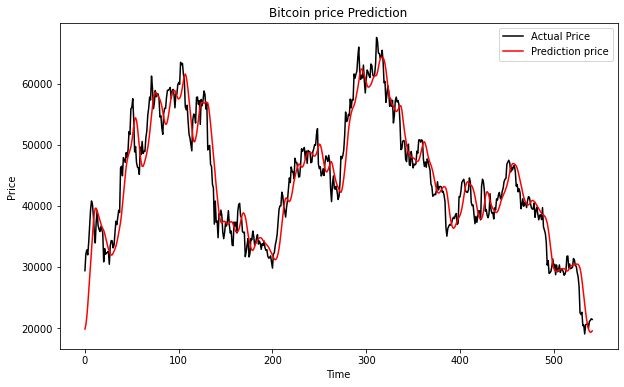

In [ ]:
plt.plot(actual_price , color = 'black' , label = 'Actual Price')
plt.plot(prediction_prices , color = 'red' , label = 'Prediction price')
plt.title('Bitcoin price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#predict next day

real_data = [input_for_model[len(input_for_model) - learning_days:len(input_for_model) + 1 , 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0] , real_data.shape[1] , 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction,'USD')

[[19823.361]] USD
